In [5]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import wrf

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [12]:
# Verbose setting
verbose = True

# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# Open the NetCDF file
ncfile_orig = os.path.join(pvlib_abspath, 'data', 'wrfout_d01_2011-01-24_01:00:00')
ncdata_orig = netCDF4.Dataset(ncfile_orig)
ncdata = xr.open_dataset(ncfile_orig)
if verbose:
    print(ncdata)

<xarray.Dataset>
Dimensions:                (Time: 24, bottom_top: 35, bottom_top_stag: 36, soil_layers_stag: 4, south_north: 191, south_north_stag: 192, west_east: 191, west_east_stag: 192)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, soil_layers_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time

In [91]:
def create_plot(cart_proj, data, data_orig, lats, lons, title_str='', save_fig=False, fig_path='./'):
    # Create a figure
    fig = plt.figure(figsize=(12,6))
    # Set the GeoAxes to the projection used by WRF
    ax = plt.axes(projection=cart_proj)

    # Make the countour lines for filled contours for the GHI
    contour_levels = np.linspace(0, 175000, 22)
    plt.contourf(to_np(lons), to_np(lats), to_np(data), contour_levels,
                 transform=crs.PlateCarree(),
                 cmap=get_cmap("summer_r"))

    # Format the plot
    format_plot(data_orig, ax, title_str)

    # Save the figure(s)
    if save_fig:
        plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [53]:
def format_plot(lim_data, ax, title_str=''):
    
    # Download and add the states, coastlines, and lakes
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.5, edgecolor="black")
#     ax.coastlines(resolution='10m', linewidth=0.8)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))

    # Add a color bar
    plt.colorbar(ax=ax, shrink=.98)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(lim_data))
    ax.set_ylim(cartopy_ylim(lim_data))

    # Add the gridlines
#     ax.gridlines(color="black", linestyle="dotted")
    
    # Add the axis title
    plt.title(title_str)

In [93]:
def plot_daily_WPD(ncdata, times, hourly=False, save_fig=False, fig_path='./'):
    air_density = 1000
    # Define the time indicies from the times variable
    time_indicies = range(0, len(times))
    # Format the times for title slides
    times_strings_f = times.dt.strftime('%b %d, %Y %H:%M')
    # Get the desired variable(s)
    for tidx in time_indicies:
        # Get the time strings
        timestr = times[tidx].values
        timestr_f = times_strings_f[tidx].values
        # Format the title string
        if hourly:
            title_str = f'Wind Power Density (kW m-2)\n{timestr_f} (UTC)'
        else:
            time_string_f = times[0].dt.strftime('%b %d, %Y')
            title_str = f'Wind Power Density (kWh m-2 day-1) \n{time_string_f.values}'
        # Get height and wind speed
        height = getvar(ncdata, "height_agl", timeidx=tidx, units='m')
        wspd = getvar(ncdata, 'wspd_wdir', timeidx=tidx, units='m s-1')[0,:]
        # Interpolate wind speeds to 100m height (also use for map projection) 
        wspd_100 = wrf.interplevel(wspd, height, 100)
        # Calculate wind power density (wind power per square meter)
        if not hourly and tidx != 0:
            WPD = WPD + 0.5 * (wspd_100) ** 3 * air_density / 1000
        else: 
            WPD = 0.5 * (wspd_100) ** 3 * air_density / 1000
            
        # Get the latitude and longitude points
        lats, lons = latlon_coords(wspd_100)

        # Get the cartopy mapping object
        cart_proj = get_cartopy(wspd_100)
        
        if hourly:
            create_plot(cart_proj, WPD, wspd_100, lats, lons, title_str, save_fig, fig_path)
    if not hourly:
        create_plot(cart_proj, WPD, wspd_100, lats, lons, title_str, save_fig, fig_path)

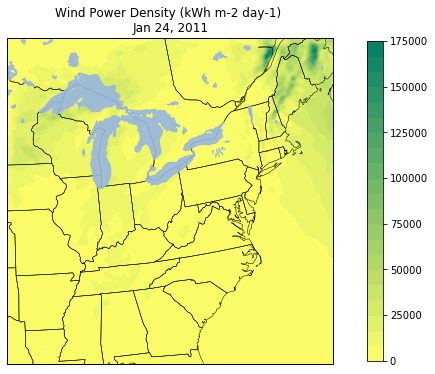

In [95]:
datestr = ncdata['XTIME'][0].dt.strftime('%b %d, %Y').values
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/daily_WPD_plot_{datestr}.png'
WPD = plot_daily_WPD(ncdata_orig, ncdata.XTIME, hourly=False, save_fig=True, fig_path=fig_path)